In [1]:
import pandas
import datetime
import urllib
import bs4
import os
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import ticker
import seaborn as sns
import scipy
import feather
%matplotlib inline

In [2]:
rel_perc_cutoff = 0.15

In [3]:
finBndDF = feather.read_dataframe('../data/trghBndDst-fits.feather')
# There is 24 MLT and 0 MLT, remove the discrepancy
finBndDF["mlt"] = finBndDF["mlt"]%24
finBndDF = finBndDF.drop_duplicates()
finBndDF["dst_bin"] = finBndDF["dst_bin"].astype(str)

In [4]:
# Discard MLTs(for each dst_bin) where num observations are low
cntNMltDstPnts = finBndDF.groupby(["dst_bin", "normMLT"]).size().reset_index()
cntNMltDstPnts.columns = ["dst_bin", "normMLT", "cnt"]

cntMaxPnts = cntNMltDstPnts[ ["dst_bin", "cnt"] ].groupby("dst_bin").max().reset_index()
cntMaxPnts.columns = ["dst_bin", "max_cnt"]

cntNMltDstPnts = pandas.merge( cntNMltDstPnts, cntMaxPnts, on=["dst_bin"] )
cntNMltDstPnts["rel_perc"] = cntNMltDstPnts["cnt"]/cntNMltDstPnts["max_cnt"]
cntNMltDstPnts = cntNMltDstPnts[ cntNMltDstPnts["rel_perc"] > rel_perc_cutoff ].reset_index(drop=True)
cntNMltDstPnts = cntNMltDstPnts[ [ "dst_bin", "normMLT", "rel_perc" ] ]
cntNMltDstPnts.head()

,dst_bin,normMLT,rel_perc
0,"(-10, 10]",-3.0,0.168704
1,"(-10, 10]",-2.0,0.353223
2,"(-10, 10]",-1.0,0.601528
3,"(-10, 10]",0.0,0.818738
4,"(-10, 10]",1.0,0.960532


In [5]:
# discard trghMean locations where obse are low
finBndDF = pandas.merge( finBndDF, cntNMltDstPnts, on=["dst_bin", "normMLT"], how="inner" )
finBndDF = finBndDF[ finBndDF["dst_bin"] == "(-10, 10]" ]

In [6]:
# Get season data
def get_season(row):
        currMonth = row["date"].month
#         return currMonth
        if ( (currMonth >= 11) or (currMonth <= 2) ):
            return "winter"#-1
        elif ( (currMonth >= 5) and (currMonth <= 8) ):
            return "summer"#1
        else:
            return "equinox"
        
finBndDF["season"] = finBndDF.apply( get_season, axis=1 )
finBndDF.head()

,date,mlatEqu,mlatMin,mlatPol,mlon,mlonAdjst,mlt,normMLT,tecEqu,tecMin,...,delTecEqu,delTecPol,delMlat,dateStr,hour,dst_date,dst_index,dst_bin,rel_perc,season
0,2011-04-18 07:15:00,47.193397,55.044765,63.016192,314.0,-46.0,23.0,-1.0,5.7,3.2,...,2.5,1.0,15.822795,20110418,07,2011-04-18 07:00:00,9.0,"(-10, 10]",0.601528,equinox
1,2011-10-23 04:40:00,49.720583,57.134677,65.579850,338.0,-22.0,23.0,-1.0,4.9,2.3,...,2.6,1.2,15.859267,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox
2,2011-10-23 04:40:00,49.720583,57.134677,65.579850,340.0,-20.0,23.0,-1.0,4.9,2.6,...,2.3,0.8,15.859267,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox
3,2011-10-23 04:40:00,49.720583,57.134677,65.579850,342.0,-18.0,23.0,-1.0,4.9,3.3,...,1.6,1.0,15.859267,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox
4,2011-10-23 04:40:00,49.720583,57.134677,65.579850,348.0,-12.0,23.0,-1.0,6.7,4.9,...,1.8,1.9,15.859267,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox


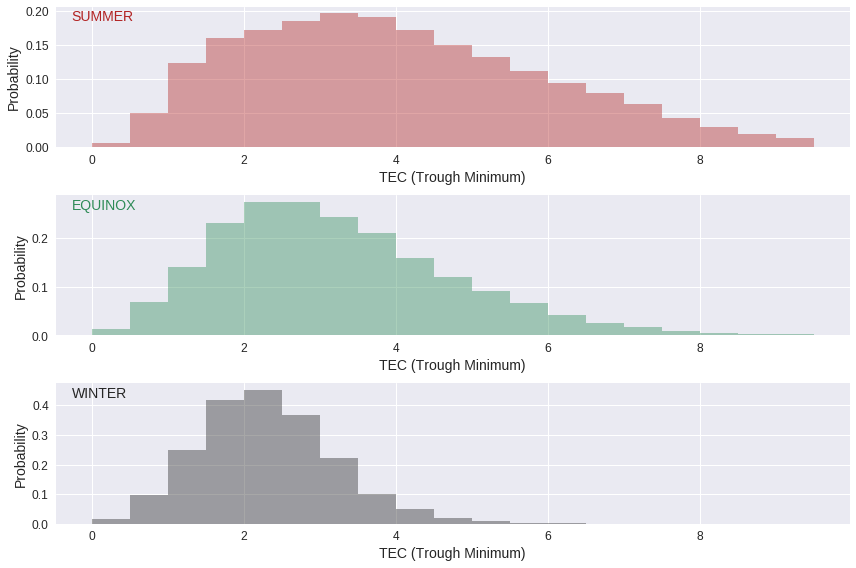

In [7]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "#252525"
colDict["equinox"] = "seagreen"

bins = numpy.arange(0,10,0.5)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["tecMin"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("TEC (Trough Minimum)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-TEC-Min.eps",bbox_inches='tight')

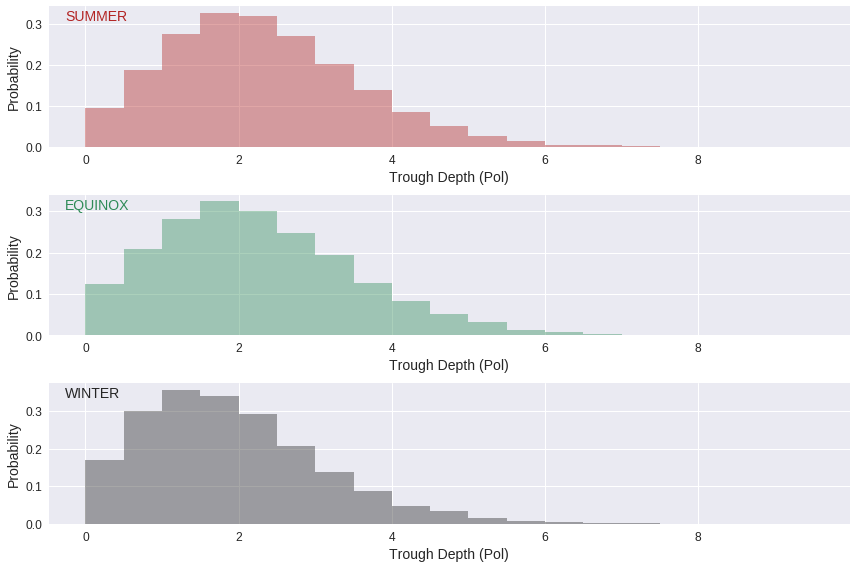

In [8]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "#252525"
colDict["equinox"] = "seagreen"

bins = numpy.arange(0,10,0.5)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["delTecPol"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("Trough Depth (Pol)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-Trgh-Dep-Pol.eps",bbox_inches='tight')

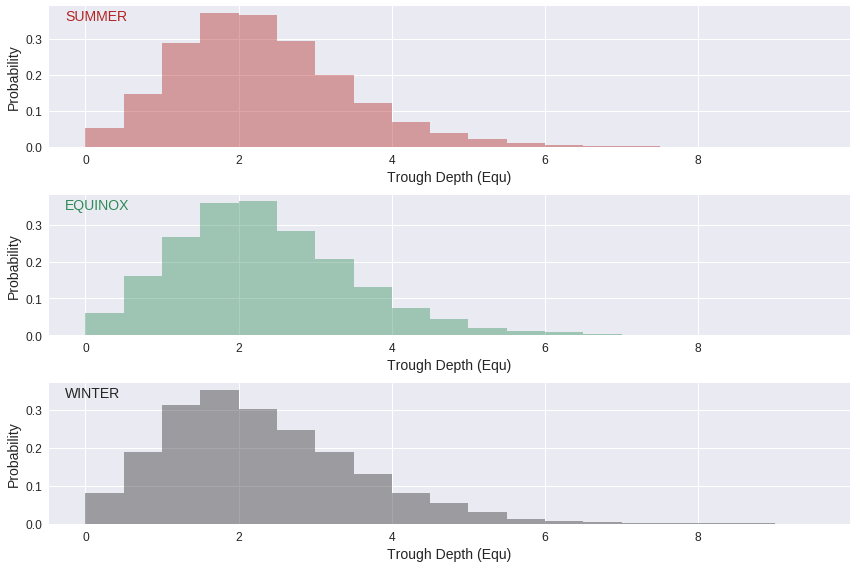

In [9]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "#252525"
colDict["equinox"] = "seagreen"

bins = numpy.arange(0,10,0.5)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["delTecEqu"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("Trough Depth (Equ)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-Trgh-Dep-Equ.eps",bbox_inches='tight')

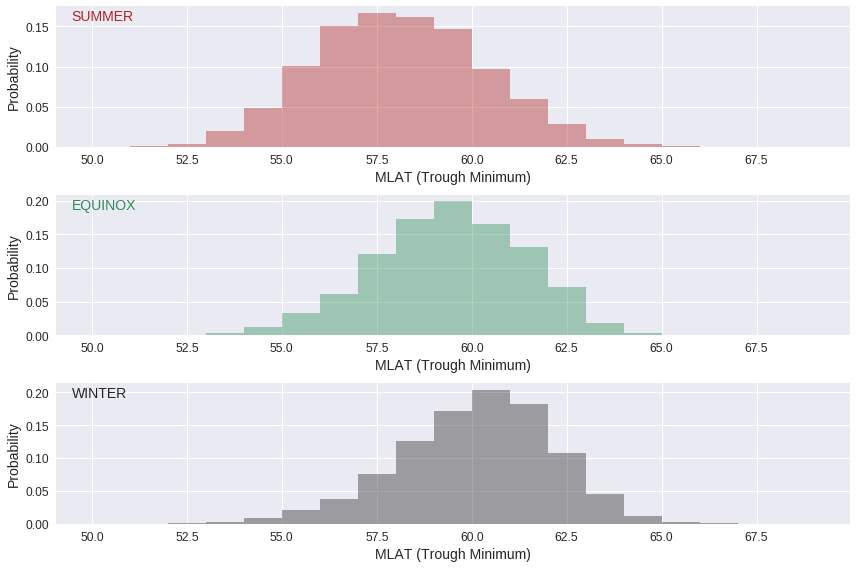

In [10]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "#252525"
colDict["equinox"] = "seagreen"

bins = numpy.arange(50,70,1)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["mlatMin"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("MLAT (Trough Minimum)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-Mlat-TEC.eps",bbox_inches='tight')

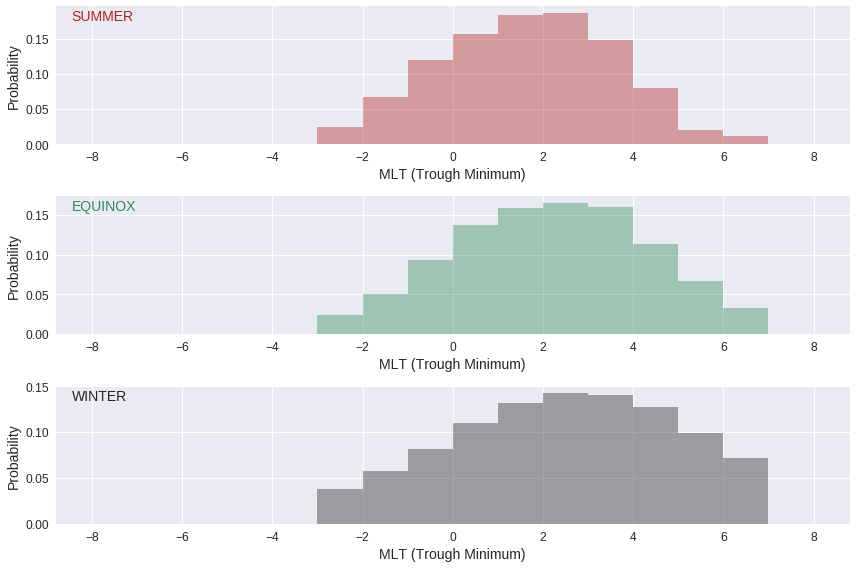

In [11]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "#252525"
colDict["equinox"] = "seagreen"

bins = numpy.arange(-8,9,1)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["normMLT"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("MLT (Trough Minimum)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-Mlt-TEC.eps",bbox_inches='tight')

In [12]:
trghSsnMeanDF = finBndDF.groupby( ["dst_bin", "normMLT", "season"] ).mean().reset_index()
trghSsnMeanDF.columns = ['dst_bin',   'normMLT',    'season',   'mlatEqu_ssn_mean',    'tecEqu_ssn_mean',
            'mlon_ssn_mean',   'mlatPol_ssn_mean',    'tecPol_ssn_mean',   'mlatMin_ssn_mean',    'tecMin_ssn_mean',
             'mlt_ssn_mean', 'mlonAdjst_ssn_mean', 'delTecEqu_ssn_mean', 'delTecPol_ssn_mean',   'delMlat_ssn_mean',
         'timeStr_ssn_mean', 'dst_index_ssn_mean',  'rel_perc_ssn_mean']
trghSsnStdDF = finBndDF.groupby( ["dst_bin", "normMLT", "season"] ).std().reset_index()
trghSsnStdDF.columns = [ 'dst_bin',   'normMLT',    'season',   'mlatEqu_ssn_std',    'tecEqu_ssn_std',
            'mlon_ssn_std',   'mlatPol_ssn_std',    'tecPol_ssn_std',   'mlatMin_ssn_std',    'tecMin_ssn_std',
             'mlt_ssn_std', 'mlonAdjst_ssn_std', 'delTecEqu_ssn_std', 'delTecPol_ssn_std',   'delMlat_ssn_std',
         'timeStr_ssn_std', 'dst_index_ssn_std',  'rel_perc_ssn_std' ]
trghSsnMeanDF = pandas.merge( trghSsnMeanDF, trghSsnStdDF, on=["dst_bin", "normMLT", "season"] )
trghSsnMeanDF.head()

,dst_bin,normMLT,season,mlatEqu_ssn_mean,tecEqu_ssn_mean,mlon_ssn_mean,mlatPol_ssn_mean,tecPol_ssn_mean,mlatMin_ssn_mean,tecMin_ssn_mean,...,mlatMin_ssn_std,tecMin_ssn_std,mlt_ssn_std,mlonAdjst_ssn_std,delTecEqu_ssn_std,delTecPol_ssn_std,delMlat_ssn_std,timeStr_ssn_std,dst_index_ssn_std,rel_perc_ssn_std
0,"(-10, 10]",-3.0,equinox,53.055733,60.057799,66.543701,285.685215,-71.453100,21.0,6.333704,...,0.0,2.086851,1.856230,2.066023,150.173232,1.177009,1.196811,3.641960,4.928992,0.0
1,"(-10, 10]",-3.0,summer,53.966376,60.875384,67.263828,281.632035,-78.367965,21.0,7.517857,...,0.0,2.261294,2.032818,2.064001,132.330703,1.335150,1.209164,3.307419,3.967501,0.0
2,"(-10, 10]",-3.0,winter,52.198179,59.896514,66.890181,292.026369,-62.496957,21.0,3.767039,...,0.0,1.277902,0.855533,1.220923,176.356380,0.954582,0.954642,3.872579,5.244515,0.0
3,"(-10, 10]",-2.0,equinox,52.095513,59.780530,66.754146,295.393894,-62.997766,22.0,5.900298,...,0.0,1.950647,1.742981,1.988495,167.270624,1.224417,1.200889,3.136181,4.845149,0.0
4,"(-10, 10]",-2.0,summer,52.286015,59.488543,66.303625,286.622312,-71.771197,22.0,7.013428,...,0.0,2.295698,2.195701,2.301832,142.989307,1.232296,1.271718,3.246725,4.524773,0.0


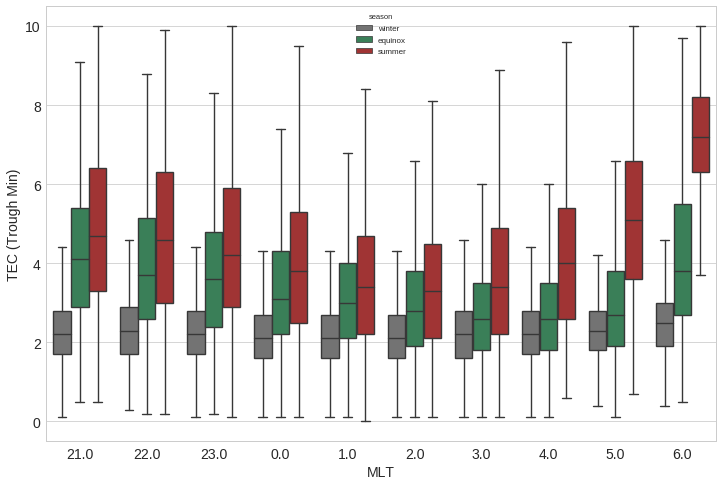

In [13]:
sns.set_style("whitegrid")
sns.set_context("paper")
# We need to plot MLTs (we are using normMLT now)
# 
colors = [ "#737373", "seagreen", "firebrick" ]
unqNrmMLTList = sorted( finBndDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
ssn_order = [ "winter", "equinox", "summer" ]
sns.boxplot( x="normMLT", y="tecMin", hue="season", data=finBndDF,\
            hue_order=ssn_order, palette=sns.color_palette(colors), showfliers=False,ax=ax1 )
# ax1.set_ylim( [0, 2000] )
# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("TEC (Trough Min)", fontsize=14)
plt.savefig("../figs/TEC-MinTrgh-MLT.eps",bbox_inches='tight')

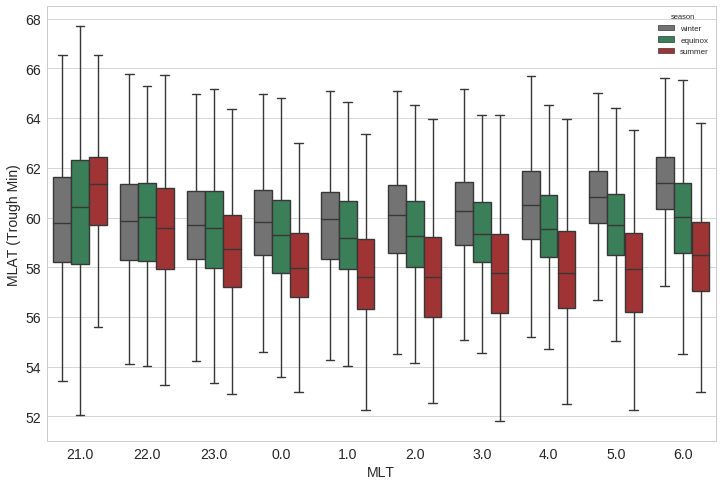

In [14]:
sns.set_style("whitegrid")
sns.set_context("paper")
# We need to plot MLTs (we are using normMLT now)
# 
colors = [ "#737373", "seagreen", "firebrick" ]
unqNrmMLTList = sorted( finBndDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
ssn_order = [ "winter", "equinox", "summer" ]
sns.boxplot( x="normMLT", y="mlatMin", hue="season", data=finBndDF,\
            hue_order=ssn_order, palette=sns.color_palette(colors), showfliers=False,ax=ax1 )
# ax1.set_ylim( [0, 2000] )
# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("MLAT (Trough Min)", fontsize=14)
plt.savefig("../figs/Mlat-MinTrgh-MLT.eps",bbox_inches='tight')

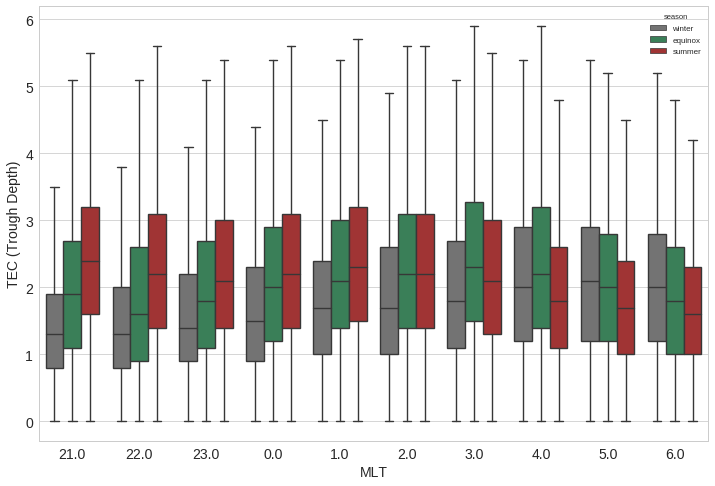

In [15]:
sns.set_style("whitegrid")
sns.set_context("paper")
# We need to plot MLTs (we are using normMLT now)
# 
colors = [ "#737373", "seagreen", "firebrick" ]
unqNrmMLTList = sorted( finBndDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
ssn_order = [ "winter", "equinox", "summer" ]
sns.boxplot( x="normMLT", y="delTecPol", hue="season", data=finBndDF,\
            hue_order=ssn_order, palette=sns.color_palette(colors), showfliers=False,ax=ax1 )
# ax1.set_ylim( [0, 2000] )
# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("TEC (Trough Depth)", fontsize=14)
plt.savefig("../figs/Trgh-Depth-Pol-MLT.eps",bbox_inches='tight')

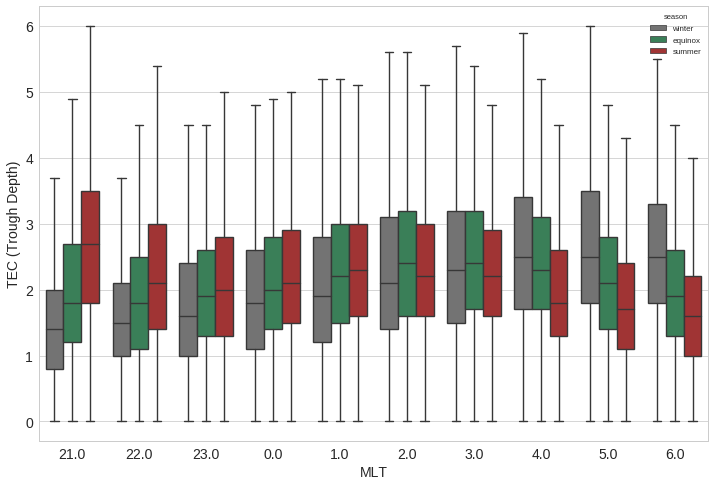

In [16]:
sns.set_style("whitegrid")
sns.set_context("paper")
# We need to plot MLTs (we are using normMLT now)
# 
colors = [ "#737373", "seagreen", "firebrick" ]
unqNrmMLTList = sorted( finBndDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
ssn_order = [ "winter", "equinox", "summer" ]
sns.boxplot( x="normMLT", y="delTecEqu", hue="season", data=finBndDF,\
            hue_order=ssn_order, palette=sns.color_palette(colors), showfliers=False,ax=ax1 )
# ax1.set_ylim( [0, 2000] )
# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("TEC (Trough Depth)", fontsize=14)
plt.savefig("../figs/Trgh-Depth-Equ-MLT.eps",bbox_inches='tight')

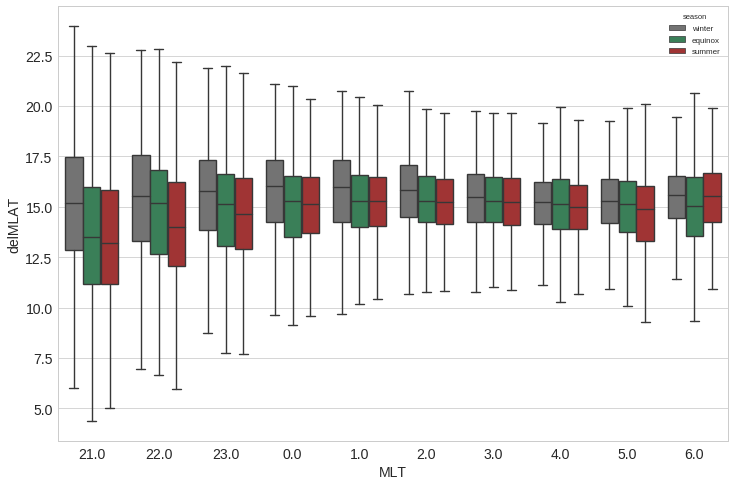

In [17]:
sns.set_style("whitegrid")
sns.set_context("paper")
# We need to plot MLTs (we are using normMLT now)
# 
colors = [ "#737373", "seagreen", "firebrick" ]
unqNrmMLTList = sorted( finBndDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
ssn_order = [ "winter", "equinox", "summer" ]
sns.boxplot( x="normMLT", y="delMlat", hue="season", data=finBndDF,\
            hue_order=ssn_order, palette=sns.color_palette(colors), showfliers=False,ax=ax1 )
# ax1.set_ylim( [0, 2000] )
# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("delMLAT", fontsize=14)
plt.savefig("../figs/Trgh-delMLAT.eps",bbox_inches='tight')

In [18]:
dstBinSel = "(-150, -50]"
selDF = finBndDF[ finBndDF["dst_bin"] == dstBinSel ].groupby("date").size().sort_values(ascending=False)
print selDF.head()

Series([], dtype: int64)


In [19]:
finBndDF.columns

Index([     u'date',   u'mlatEqu',   u'mlatMin',   u'mlatPol',      u'mlon',
       u'mlonAdjst',       u'mlt',   u'normMLT',    u'tecEqu',    u'tecMin',
          u'tecPol',   u'timeStr', u'delTecEqu', u'delTecPol',   u'delMlat',
         u'dateStr',      u'hour',  u'dst_date', u'dst_index',   u'dst_bin',
        u'rel_perc',    u'season'],
      dtype='object')